Found 9867 images belonging to 4 classes.
Found 2465 images belonging to 4 classes.
Found 3076 images belonging to 4 classes.
Epoch 1/10
309/309 [==============================] - 743s 2s/step - loss: 0.6064 - accuracy: 0.7658 - val_loss: 1.3228 - val_accuracy: 0.3318
Epoch 2/10
309/309 [==============================] - 771s 2s/step - loss: 0.4295 - accuracy: 0.8283 - val_loss: 0.6063 - val_accuracy: 0.7327
Epoch 3/10
309/309 [==============================] - 724s 2s/step - loss: 0.4127 - accuracy: 0.8322 - val_loss: 0.2872 - val_accuracy: 0.8852
Epoch 4/10
309/309 [==============================] - 643s 2s/step - loss: 0.3809 - accuracy: 0.8433 - val_loss: 0.2685 - val_accuracy: 0.8945
Epoch 5/10
309/309 [==============================] - 626s 2s/step - loss: 0.3777 - accuracy: 0.8425 - val_loss: 0.2742 - val_accuracy: 0.8844
Epoch 6/10
309/309 [==============================] - 626s 2s/step - loss: 0.3646 - accuracy: 0.8503 - val_loss: 0.2698 - val_accuracy: 0.8884
Epoch 7/10
309/3

C:\Users\nksdk\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 151s 1s/step


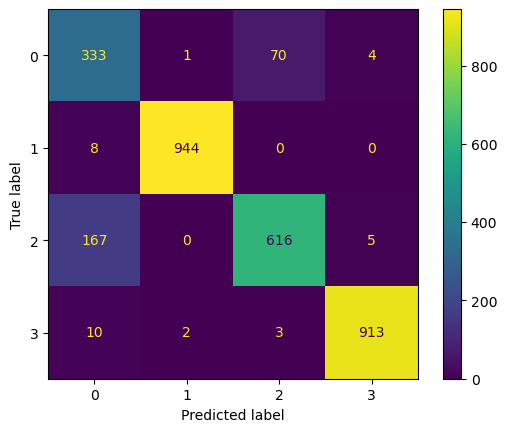

              precision    recall  f1-score   support

           0       0.64      0.82      0.72       408
           1       1.00      0.99      0.99       952
           2       0.89      0.78      0.83       788
           3       0.99      0.98      0.99       928

    accuracy                           0.91      3076
   macro avg       0.88      0.89      0.88      3076
weighted avg       0.92      0.91      0.91      3076



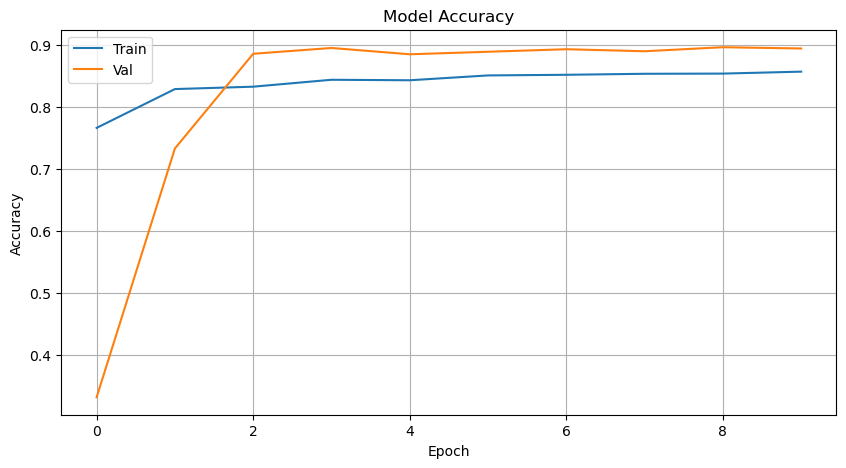

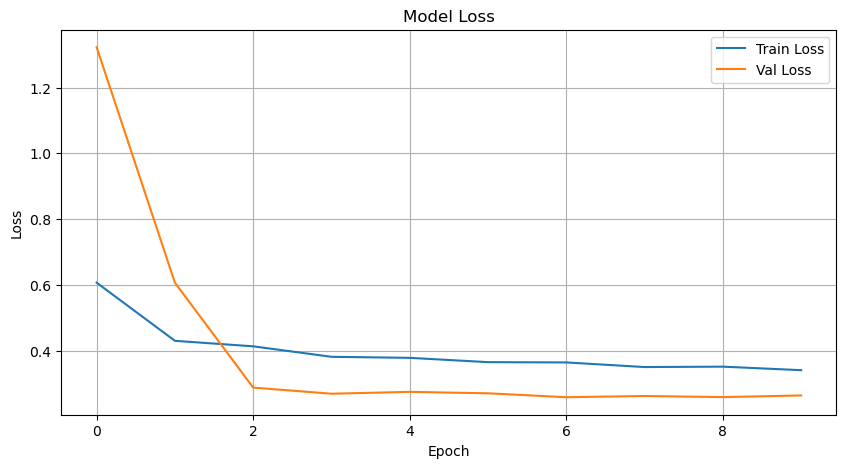

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os

# Define file paths
train_file_path = 'Train'
test_file_path = 'Test'

# Parameters
valid_split = 0.2
input_size = (224, 224)
image_color = 'rgb'
batch_size = 32
shuffle = True
epochs = 10  # Adjust as needed

# Create ImageDataGenerators
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=valid_split
)

test_gen = ImageDataGenerator(rescale=1/255.0)

# Flow from directory for training and validation
train_data = train_gen.flow_from_directory(
    directory=train_file_path,
    target_size=input_size,
    color_mode=image_color,
    batch_size=batch_size,
    shuffle=shuffle,
    class_mode='categorical',
    subset='training'
)

valid_data = train_gen.flow_from_directory(
    directory=train_file_path,
    target_size=input_size,
    color_mode=image_color,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

# Flow from directory for testing
test_data = test_gen.flow_from_directory(
    directory=test_file_path,
    target_size=input_size,
    color_mode=image_color,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Model building
input_shape = (224, 224, 3)
num_classes = train_data.num_classes

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Keep frozen

# Custom head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=valid_data, epochs=epochs)

# Save model
model.save("efficientnet.h5")

# Evaluate
model = tf.keras.models.load_model("efficientnet.h5")
preds = model.predict(test_data)
pred_labels = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_data.classes, pred_labels)
ConfusionMatrixDisplay(cm).plot()
plt.show()
print(classification_report(test_data.classes, pred_labels))

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()